# El tasador de productos (continuación)

Un modelo que puede estimar cuánto cuesta algo a partir de su descripción.

## Modelos de referencia

Hoy trabajamos con los modelos más simples para que sirvan como punto de partida y los superemos.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# Más importaciones para nuestro aprendizaje automático tradicional

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Y más importaciones para nuestro aprendizaje automático relacionado con PNL

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Log in en HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
%matplotlib inline

# Carga de los archivos pkl

¡Evitemos tener que volver a seleccionar todos nuestros datos! Carga los archivos pickle

Si aún no los creaste en el día 2, también puedes descargarlos desde mi Google Drive (también encontrarás las diapositivas aquí):
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

Pero ten en cuenta que los archivos son bastante grandes; ¡quizás necesites tomar un café!

In [9]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [10]:
# Recordarnos el prompt del entrenamiento

print(train[0].prompt)

¿Cuánto cuesta esto redondeado al dólar más cercano?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [13]:
# Recordarnos el prompt del testing

print(train[0].price)

226.95


## ¡Revelamos un poderoso script que usaremos mucho!

Un arnés de prueba bastante agradable que evaluará cualquier modelo en comparación con 250 elementos del conjunto de prueba

Y nos mostrará los resultados de una manera visualmente satisfactoria.

Escribe una función de este formato:

```
def my_prediction_function(item):
    # mi código aquí
    return my_estimate
```

Y luego llamas a:

`Tester.test(my_prediction_function)`

Para evaluar tu modelo.

In [14]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Predicción: ${guess:,.2f} Valor Real: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Valor Real')
        plt.ylabel('Estimación del modelo')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Ahora, algo básico

¿Cuál es el modelo más simple que puedas imaginar?

¡Comencemos con un generador de números aleatorios!

In [15]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Predicción: $655.00 Valor Real: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Predicción: $115.00 Valor Real: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Predicción: $26.00 Valor Real: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Predicción: $760.00 Valor Real: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Predicción: $282.00 Valor Real: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Predicción: $251.00 Valor Real: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Predicción: $229.00 Valor Real: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Predicción: $143.00 Valor Real: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Predicción: $755.00 Valor Real: $635.86 Error: $119.14 SLE: 0.03 Item: Ra

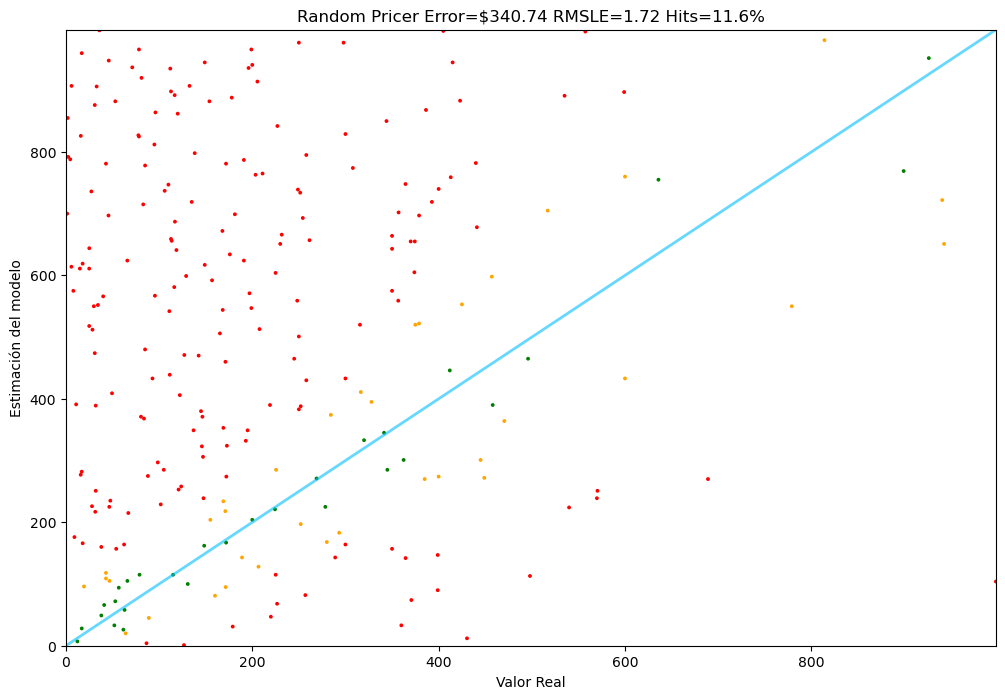

In [16]:
# Elegimos una semilla aleatoria

random.seed(42)

# Ejetuamos el TestRunner
Tester.test(random_pricer)

In [17]:
# ¡Eso fue divertido!
# Podemos hacerlo mejor: aquí hay otro modelo bastante trivial

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Predicción: $220.46 Valor Real: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Predicción: $220.46 Valor Real: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Predicción: $220.46 Valor Real: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Predicción: $220.46 Valor Real: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Predicción: $220.46 Valor Real: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Predicción: $220.46 Valor Real: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Predicción: $220.46 Valor Real: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Predicción: $220.46 Valor Real: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Predicción: $220.46 Valor Real: $635.86 Error: $415.40 SLE: 1.12 Item: Ran

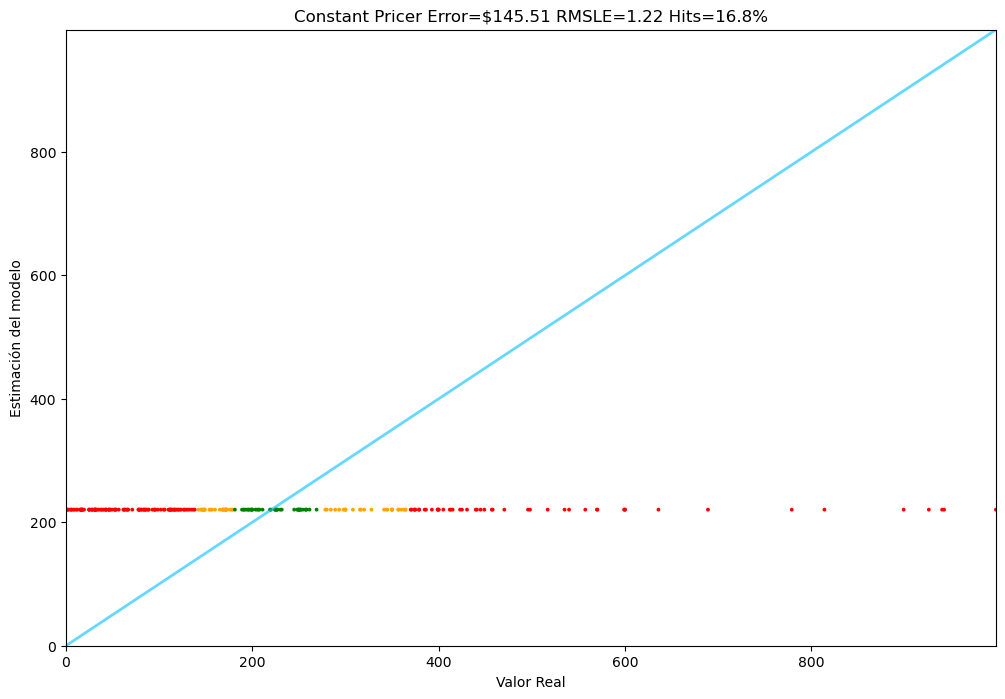

In [18]:
# Ejecutamos el entrenamiento a valor constante
Tester.test(constant_pricer)


In [19]:
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

In [20]:
# Cree un nuevo campo de "características" en los elementos y complételo con json analizado desde el diccionario de detalles

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [22]:
train[0].features

{'Brand': 'Delphi',
 'Fit Type': 'Vehicle Specific Fit',
 'Item Dimensions LxWxH': '19.7 x 7.7 x 5.1 inches',
 'Item Weight': '2.2 Pounds',
 'Auto Part Position': 'Unknown',
 'Operation Mode': 'Mechanical',
 'Manufacturer': 'Delphi',
 'Model': 'FUEL PUMP',
 'Product Dimensions': '19.7 x 7.7 x 5.1 inches',
 'Country of Origin': 'USA',
 'Item model number': 'FG0166',
 'Is Discontinued By Manufacturer': 'No',
 'Exterior': 'Painted',
 'Manufacturer Part Number': 'FG0166',
 'OEM Part Number': '25326856, 89060639, A30416, E4061R, MU242',
 'Best Sellers Rank': {'Automotive': 913571,
  'Automotive Replacement Electric Fuel Pumps': 6568},
 'Domestic Shipping': 'Item can be shipped within U.S.',
 'International Shipping': 'This item is not eligible for international shipping.  Learn More',
 'Date First Available': 'August 9, 2006'}

In [23]:
# Observa las 20 características más comunes en el conjunto de entrenamiento

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [24]:
# Ahora, un código aparatoso para extraer el peso del artículo
# No te preocupes demasiado por esto: alerta de spoiler: no será de mucha utilidad en el entrenamiento.

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [25]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [26]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [27]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [28]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [29]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [30]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [31]:
def get_text_length(item):
    return len(item.test_prompt())

In [32]:
# investigamos las marcas

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Miramos las 40 marcas más comunes

brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [33]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [34]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [35]:
# Observamos las características de un elemento de entrenamiento
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 754,
 'is_top_electronics_brand': 0}

In [36]:
# Una función de utilidad para convertir nuestras características en un data frame de pandas

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [37]:
# ¡Regresión lineal tradicional!

np.random.seed(42)

# Separamos las características y el target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Entrenamos la regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Ordenada en el orígen: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio: {mse}")
print(f"Puntuación R-cuadrado: {r2}")

weight: 0.26423218629576695
rank: 5.197480233116636e-05
text_length: 0.007609328351322259
is_top_electronics_brand: 198.14254283207853
Ordenada en el orígen: 182.1409639088643
Error cuadrático medio: 33034.336771967886
Puntuación R-cuadrado: 0.09091571194865511


In [38]:
# Función para predecir el precio de un nuevo artículo

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Predicción: $228.68 Valor Real: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Predicción: $214.45 Valor Real: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Predicción: $191.46 Valor Real: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Predicción: $389.92 Valor Real: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Predicción: $211.35 Valor Real: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Predicción: $211.42 Valor Real: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Predicción: $190.88 Valor Real: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Predicción: $190.14 Valor Real: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Predicción: $220.89 Valor Real: $635.86 Error: $414.97 SLE: 1.11 Item: Ran

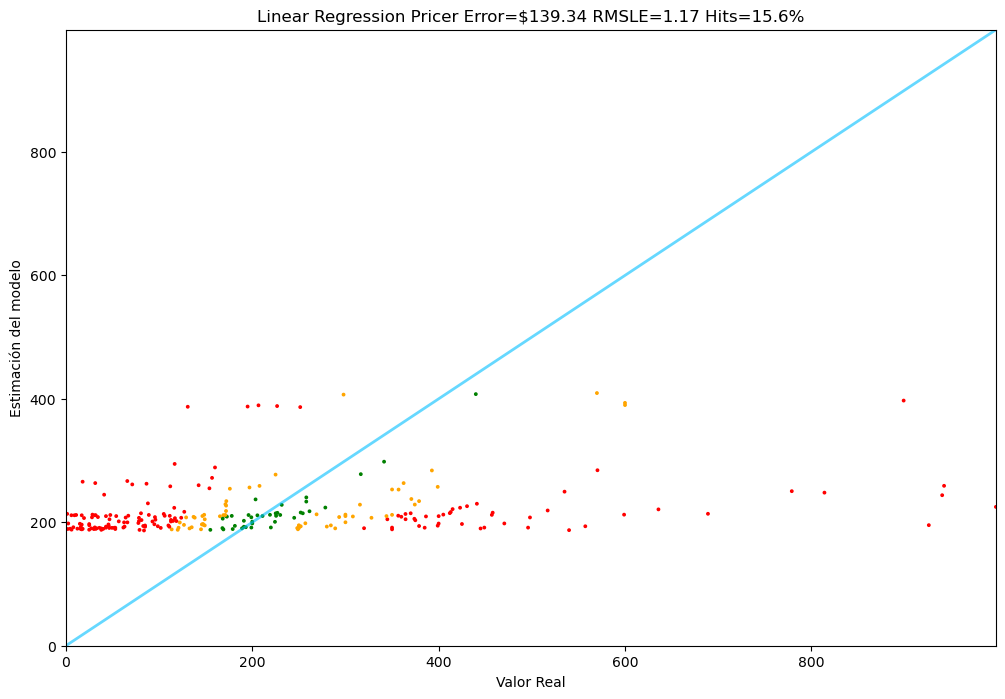

In [39]:
# La probamos

Tester.test(linear_regression_pricer)

In [40]:
# Para los próximos modelos, preparamos nuestros documentos y precios
# ¡Tenga en cuenta que utilizamos el mensaje de prueba para los documentos, de lo contrario revelaremos la respuesta!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [41]:
# Utilizamos CountVectorizer para un modelo de bolsa de palabras

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [42]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Predicción: $296.91 Valor Real: $374.41 Error: $77.50 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Predicción: $164.92 Valor Real: $225.11 Error: $60.19 SLE: 0.10 Item: Motorcraft YB3125 Fan Clutch
3: Predicción: $162.45 Valor Real: $61.68 Error: $100.77 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Predicción: $326.64 Valor Real: $599.99 Error: $273.35 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Predicción: $51.24 Valor Real: $16.99 Error: $34.25 SLE: 1.14 Item: 5-Position Super Switch Pickup Selector ...
6: Predicción: $74.62 Valor Real: $31.99 Error: $42.63 SLE: 0.69 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Predicción: $345.74 Valor Real: $101.79 Error: $243.95 SLE: 1.48 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Predicción: $240.87 Valor Real: $289.00 Error: $48.13 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Predicción: $405.01 Valor Real: $635.86 Error: $230.85 SLE: 0.20 Item: Randall

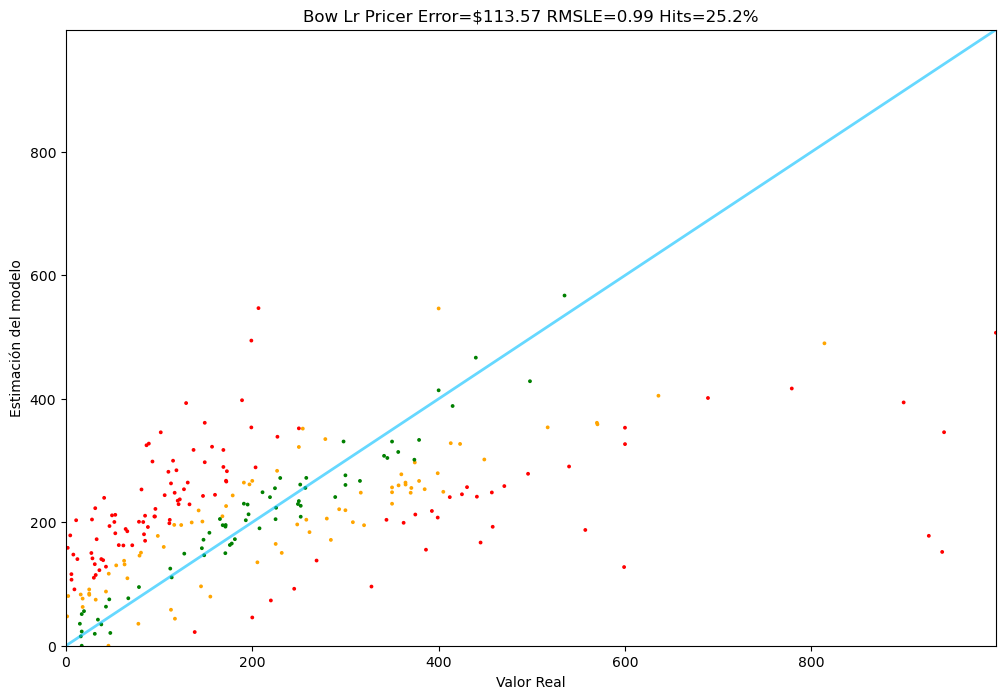

In [43]:
# Lo probamos

Tester.test(bow_lr_pricer)

In [44]:
# El fascinante modelo word2vec, implementado con la librería gensim NLP

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [45]:
# Este paso de promediar vectores en todo el documento es una debilidad en nuestro enfoque.

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Creamos la matriz de características
X_w2v = np.array([document_vector(doc) for doc in documents])

In [46]:
# Ejecutamos la regresión lineal en word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [47]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Predicción: $247.89 Valor Real: $374.41 Error: $126.52 SLE: 0.17 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Predicción: $189.47 Valor Real: $225.11 Error: $35.64 SLE: 0.03 Item: Motorcraft YB3125 Fan Clutch
3: Predicción: $131.26 Valor Real: $61.68 Error: $69.58 SLE: 0.56 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Predicción: $351.46 Valor Real: $599.99 Error: $248.53 SLE: 0.28 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Predicción: $119.25 Valor Real: $16.99 Error: $102.26 SLE: 3.61 Item: 5-Position Super Switch Pickup Selector ...
6: Predicción: $0.00 Valor Real: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Predicción: $310.79 Valor Real: $101.79 Error: $209.00 SLE: 1.23 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Predicción: $253.12 Valor Real: $289.00 Error: $35.88 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Predicción: $339.20 Valor Real: $635.86 Error: $296.66 SLE: 0.39 Item: Randa

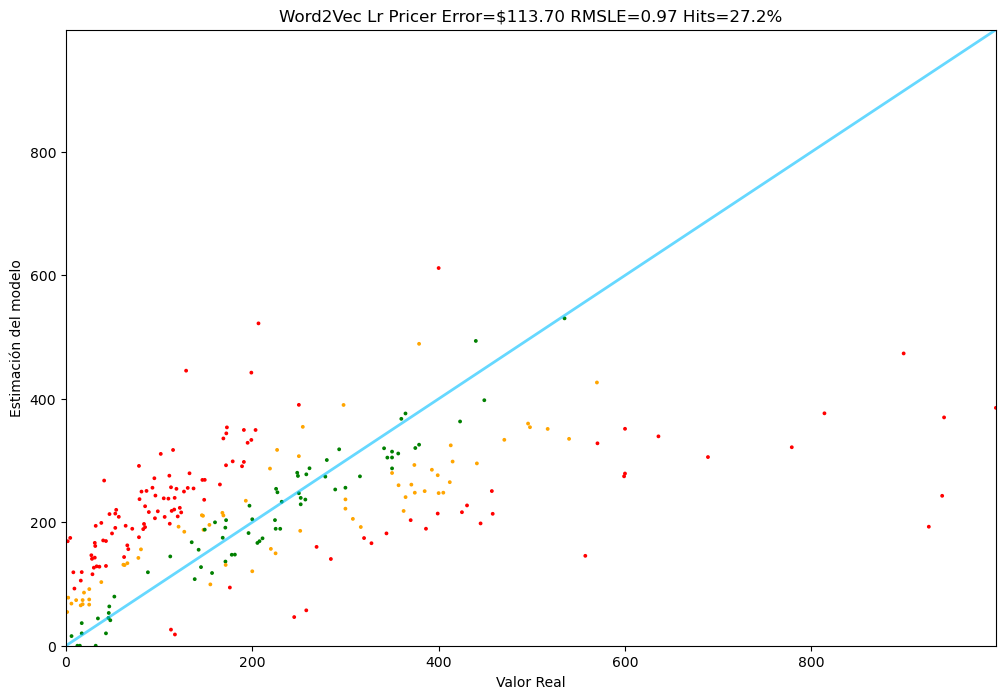

In [48]:
Tester.test(word2vec_lr_pricer)

In [49]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [50]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Predicción: $233.54 Valor Real: $374.41 Error: $140.87 SLE: 0.22 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Predicción: $170.87 Valor Real: $225.11 Error: $54.24 SLE: 0.08 Item: Motorcraft YB3125 Fan Clutch
3: Predicción: $113.25 Valor Real: $61.68 Error: $51.57 SLE: 0.36 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Predicción: $294.35 Valor Real: $599.99 Error: $305.64 SLE: 0.50 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Predicción: $91.22 Valor Real: $16.99 Error: $74.23 SLE: 2.67 Item: 5-Position Super Switch Pickup Selector ...
6: Predicción: $0.00 Valor Real: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Predicción: $252.37 Valor Real: $101.79 Error: $150.58 SLE: 0.81 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Predicción: $192.02 Valor Real: $289.00 Error: $96.98 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Predicción: $275.66 Valor Real: $635.86 Error: $360.20 SLE: 0.70 Item: Randall

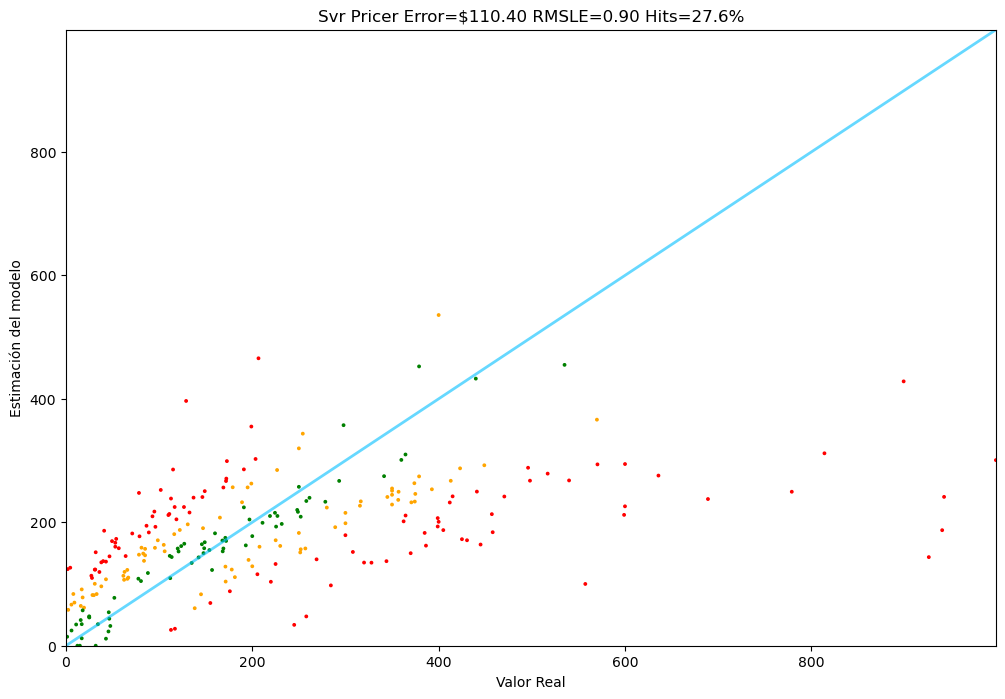

In [51]:
Tester.test(svr_pricer)

In [52]:
# Y el poderosísimo Random Forest para regresión

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [53]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Predicción: $330.39 Valor Real: $374.41 Error: $44.02 SLE: 0.02 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Predicción: $201.71 Valor Real: $225.11 Error: $23.40 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Predicción: $165.84 Valor Real: $61.68 Error: $104.16 SLE: 0.96 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Predicción: $399.71 Valor Real: $599.99 Error: $200.28 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Predicción: $141.63 Valor Real: $16.99 Error: $124.64 SLE: 4.29 Item: 5-Position Super Switch Pickup Selector ...
6: Predicción: $43.86 Valor Real: $31.99 Error: $11.87 SLE: 0.09 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Predicción: $261.89 Valor Real: $101.79 Error: $160.10 SLE: 0.88 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Predicción: $258.50 Valor Real: $289.00 Error: $30.50 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Predicción: $280.82 Valor Real: $635.86 Error: $355.04 SLE: 0.66 Item: Randa

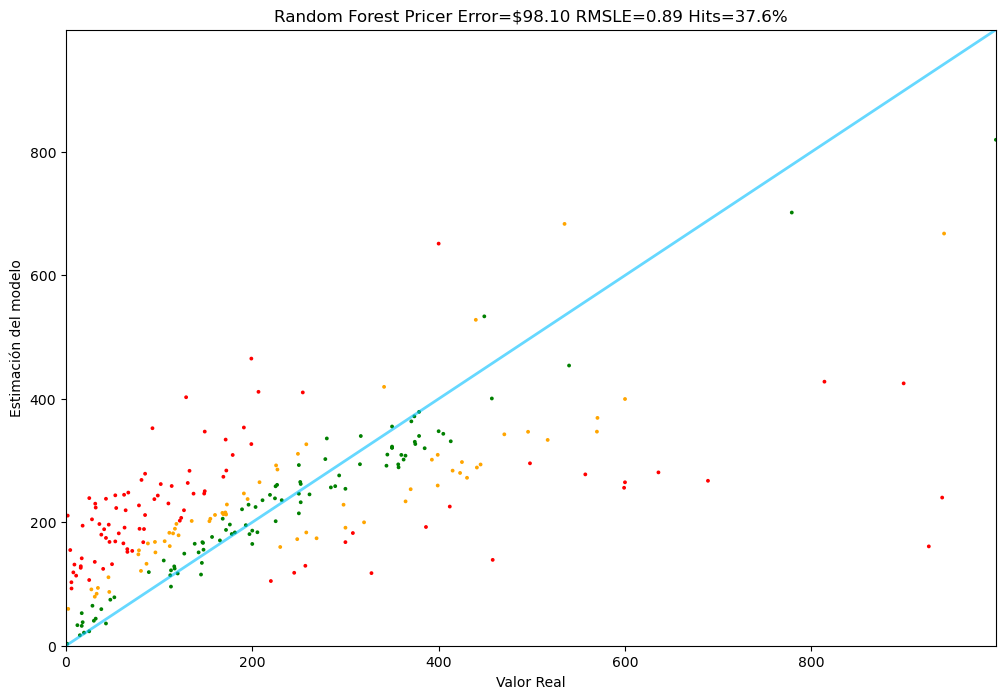

In [54]:
Tester.test(random_forest_pricer)